# Urban Demography — Supplementary Figures (Clean Version)

**Author:** Andrew Zimmer  
**Created:** 2024-11-14  
**Last Edited:** 2026-02-19  
**Version:** 2.0 (public-facing, cleaned)

This notebook generates all supplementary figures and tables for the GUDD manuscript, using a consolidated, reproducible, and well-commented workflow. All code is optimized for clarity and public sharing.

---

## 1. Imports, Global Settings, and Reproducibility
Import all required libraries, set global plotting and output folder variables, and print package versions for reproducibility.

In [45]:
import sys
import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle, ConnectionPatch
from matplotlib.gridspec import GridSpec
from matplotlib.font_manager import FontProperties
import seaborn as sns

# Print package versions for reproducibility
print("Python version:", sys.version)
print("pandas:", pd.__version__)
print("geopandas:", gpd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", mpl.__version__)
print("seaborn:", sns.__version__)

# Set deterministic seed for reproducibility (if needed)
np.random.seed(42)

# Set output and data folders
DATA_FOLDER = Path('../01_data/')
FIGURE_FOLDER = Path('../03_documents/02_supplement_figures/')
os.makedirs(FIGURE_FOLDER, exist_ok=True)

# Set matplotlib global rcParams for consistent style
mpl.rcParams['pdf.fonttype'] = 42  # TrueType fonts for better PDF compatibility
mpl.rcParams['font.family'] = 'DejaVu Sans Mono'
mpl.rcParams['font.size'] = 9
sns.set(style="whitegrid")

Python version: 3.14.2 (main, Dec  5 2025, 16:49:16) [Clang 17.0.0 (clang-1700.6.3.2)]
pandas: 3.0.0
geopandas: 1.1.2
numpy: 2.4.2
matplotlib: 3.10.8
seaborn: 0.13.2


In [46]:
# Load world boundaries for all map plots
global world
world = gpd.read_file(DATA_FOLDER / '02_auxiliary_data/03_mapping/ne_50m_admin_0_countries.shp')

## 2. Colormaps, Palettes, and Normalization Helpers
Define and register all colormaps and palettes used across figures. Provide helper for truncated colormaps.

In [47]:
def truncated_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Return a truncated colormap."""
    return mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n)))

# Dependency ratio colormaps
cmap_dr = plt.get_cmap("viridis")
cmap_delta = truncated_colormap(plt.get_cmap("inferno"), 0.1, 0.9)

# Sex ratio colormaps
cmap_sr = plt.get_cmap("YlOrRd")
cmap_delta_sr = plt.get_cmap("YlGnBu")

# Migration custom colormap
migration_colors = [
    '#fdd070', '#fdae61', '#f98e52', '#f46d43', '#e34a33', '#d73027',
    '#c51b7d', '#ae017e', '#8c0273', '#5f0165', '#2b0040'
]
migration_cmap = mcolors.LinearSegmentedColormap.from_list("migration", migration_colors)

# Palettes for boxplots
boxplot_palette = {"2000": "#FFB000", "2020": "#0072B2"}
city_size_order = ["<50k", "50-300k", "300K-1M", "1-5M", ">5M"]

# Normalizations
norm_dr = mpl.colors.Normalize(vmin=0.2, vmax=1.2)
norm_delta = mpl.colors.Normalize(vmin=-0.3, vmax=0.3)
norm_migration = mpl.colors.Normalize(vmin=0, vmax=100)


## 3. Font, Layout, and Plotting Utilities
Define font properties, set rcParams, and provide helper functions for formatting, saving, and city size labeling.

In [48]:
mono_font = FontProperties(family="DejaVu Sans Mono", size=9)
label_font = FontProperties(family="DejaVu Sans Mono", size=7)
legend_font = FontProperties(family="DejaVu Sans Mono", size=7)

# Helper: format tick labels for millions
format_millions = lambda y, _: f"{int(y/1e6)}M" if y > 0 else "0"

def safe_savefig(output_path, fig, dpi=300):
    """Save figure to disk with tight bounding box and error handling."""
    try:
        fig.savefig(output_path, format="pdf", bbox_inches='tight', pad_inches=0, dpi=dpi)
        print(f"Saved: {output_path}")
    except Exception as e:
        print(f"Error saving {output_path}: {e}")

def city_size_label(pop):
    """Categorize city size for boxplots and migration panels."""
    if pop <= 50000:
        return "<50k"
    elif pop <= 300000:
        return "50-300k"
    elif pop <= 1000000:
        return "300K-1M"
    elif pop <= 5000000:
        return "1-5M"
    else:
        return ">5M"


## 4. Map Plotting Helpers
Reusable functions for map plotting, region/inset boxes, connectors, and color tweaks.

In [49]:
def darken_color(c, amount=0.6):
    c_rgb = mcolors.to_rgb(c)
    return tuple(np.array(c_rgb) * amount)

def plot_map(ax, data, column, cmap, vmin, vmax, title, letter=None, inset=False, region_box=False, inset_box=False, highlight_points=None):
    world.plot(ax=ax, color="#E6E6E6", edgecolor="0.5", linewidth=0.3, zorder=1)
    base_size = 8 if inset else 2
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = cmap(norm(data[column]))
    edge_colors = np.array([darken_color(c[:3], 0.6) + (c[3],) for c in rgba_colors])
    sc = ax.scatter(
        data["longitude"], data["latitude"],
        c=rgba_colors, s=base_size, zorder=2
    )
    if highlight_points is not None and len(highlight_points):
        hl_size = 40 if inset else 8
        ax.scatter(
            highlight_points["longitude"], highlight_points["latitude"],
            s=hl_size, facecolor="#ffc425", edgecolor="black", linewidth=0.3, zorder=3, label="Cities Δ > 0.5"
        )
    if region_box:
        draw_region_box(ax)
    if inset_box:
        draw_inset_panel_box(ax)
    if inset:
        ax.set_xlim(26, 76)
        ax.set_ylim(15, 40)
    else:
        ax.set_xlim(-180, 180)
        ax.set_ylim(-55, 90)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_title(title, fontproperties=mono_font, fontsize=9, pad=4)
    if letter:
        ax.text(0.02, 0.95, letter, transform=ax.transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="top", ha="left", zorder=3)
    return sc, norm

def draw_region_box(ax):
    rect = Rectangle((26, 15), 50, 25, fill=False, linestyle="--", linewidth=0.8, edgecolor="black", zorder=4)
    ax.add_patch(rect)

def draw_inset_panel_box(ax):
    rect = Rectangle((0,0), 1, 1, transform=ax.transAxes, fill=False, linewidth=1, edgecolor="black", zorder=5)
    ax.add_patch(rect)

def connect_axes(fig, ax_main, ax_inset):
    con1 = ConnectionPatch(xyA=(26, 40), coordsA=ax_main.transData, xyB=(0,1), coordsB=ax_inset.transAxes, linestyle="--", linewidth=0.8, color="black")
    con2 = ConnectionPatch(xyA=(76, 40), coordsA=ax_main.transData, xyB=(1,1), coordsB=ax_inset.transAxes, linestyle="--", linewidth=0.8, color="black")
    fig.add_artist(con1)
    fig.add_artist(con2)


# Section S2 - Detailed Stats Table for 5 Largest Cities in Each Region

In [50]:
# Filter data for 2000-2020
df_full = pd.read_csv(DATA_FOLDER / '04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv')
df_full = df_full[(df_full['year'] >= 2000) & (df_full['year'] <= 2020)].copy()

# Aggregate over 2000-2020 by city
agg_df = df_full.groupby(['Continent','Name','Country'], as_index=False).agg(
    total_pop=('total_pop', 'max'),  # use 2020 population
    pop_change=('pop_change', 'sum'),
    births=('births', 'sum'),
    deaths_total=('deaths_total', 'sum'),
    natural_change=('natural_change', 'sum'),
    migration=('migration', 'sum')
)

# Get top 5 cities per continent by 2020 population
top_cities_per_continent = agg_df.groupby('Continent', group_keys=False).apply(lambda x: x.nlargest(5, 'total_pop'))

# Rename columns
top_cities_per_continent = top_cities_per_continent.rename(columns={
    'total_pop': 'Total Population (2020)',
    'pop_change': 'Population Change (2000-2020)',
    'births': 'Total Births (2000-2020)',
    'deaths_total': 'Total Deaths (2000-2020)',
    'natural_change': 'Natural Change (2000-2020)',
    'migration': 'Net Migration (2000-2020)'
}).reset_index(drop=True)

output_file = FIGURE_FOLDER / 'top_cities_per_continent.csv'
top_cities_per_continent.to_csv(output_file, index=False)
top_cities_per_continent.head()

,Name,Country,Total Population (2020),Population Change (2000-2020),Total Births (2000-2020),Total Deaths (2000-2020),Natural Change (2000-2020),Net Migration (2000-2020)
0,Sydney,Australia,3.346587e+06,1189.744141,938486.690971,416581.774373,476042.011296,-474852.267156
1,Melbourne,Australia,3.033334e+06,2821.843750,784785.854073,354098.677325,392337.063717,-389515.219967
2,Auckland,New Zealand,1.285476e+06,266182.061035,349336.053474,128945.162223,202567.461957,63614.599078
3,Perth,Australia,1.132860e+06,1576.141602,295019.339796,126219.152902,154364.393388,-152788.251787
4,Brisbane,Australia,1.085192e+06,1638.145020,294414.250230,122020.334955,157945.140055,-156306.995035


# Section S3 - Young Sex Ratio

Saved: ../03_documents/02_supplement_figures/figs3_ysr_map.pdf


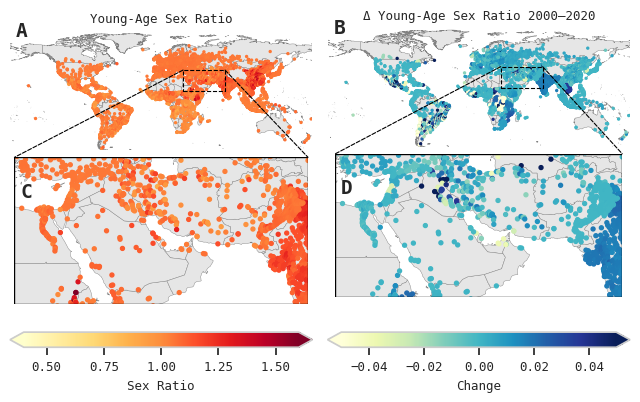

In [51]:
# Section S3 - Young Sex Ratio (with main figure style and colorbars)
# Load and filter data
annual_metrics = pd.read_csv(DATA_FOLDER / '04_final_demographic_data/01_static_boundaries/gudd_annual_metrics_static_boundaries.csv')
change_data = pd.read_csv(DATA_FOLDER / '04_final_demographic_data/01_static_boundaries/gudd_change_2000_2020_static_boundaries.csv')
annual_metrics_2020 = annual_metrics[(annual_metrics['YearOfBirth'] <= 2000) & (annual_metrics['YearOfDeath'] >= 2020) & (annual_metrics['year'] == 2020)].copy()
change_data = change_data[(change_data['YearOfBirth'] <= 2000) & (change_data['YearOfDeath'] >= 2020)].copy()

highlight = change_data[change_data['young_sr_Delta'] > 0.5]
highlight_sr = annual_metrics_2020[annual_metrics_2020['young_sr'] > 2]

fig, axes = plt.subplots(2, 2, figsize=(8, 4.5), gridspec_kw={'hspace':0.05, 'wspace':0.05})

# Main maps
sc1, _ = plot_map(axes[0,0], annual_metrics_2020, 'young_sr', cmap_sr, 0.4, 1.6, 'Young-Age Sex Ratio', region_box=True, highlight_points=highlight_sr)
vmin_delta, vmax_delta = -0.05, 0.05
sc2, _ = plot_map(axes[0,1], change_data, 'young_sr_Delta', cmap_delta_sr, vmin_delta, vmax_delta, 'Δ Young-Age Sex Ratio 2000–2020', region_box=True, highlight_points=highlight)
# Inset maps
sc3, _ = plot_map(axes[1,0], annual_metrics_2020, 'young_sr', cmap_sr, 0.4, 1.6, '', inset=True, inset_box=True, highlight_points=highlight_sr)
sc4, _ = plot_map(axes[1,1], change_data, 'young_sr_Delta', cmap_delta_sr, vmin_delta, vmax_delta, '', inset=True, inset_box=True, highlight_points=highlight)

# Subplot letters
axes[0,0].text(0.02, 0.9, "A", transform=axes[0,0].transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="bottom", ha="left", zorder=3)
axes[0,1].text(0.02, 0.9, "B", transform=axes[0,1].transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="bottom", ha="left", zorder=3)
axes[1,0].text(0.02, 0.7, "C", transform=axes[1,0].transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="bottom", ha="left", zorder=3)
axes[1,1].text(0.02, 0.7, "D", transform=axes[1,1].transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="bottom", ha="left", zorder=3)

# Connectors
connect_axes(fig, axes[0,0], axes[1,0])
connect_axes(fig, axes[0,1], axes[1,1])

# Colorbars (explicit colormaps, extended)
cbar1 = fig.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(0.4, 1.6), cmap=cmap_sr),
    ax=[axes[0,0], axes[1,0]], orientation="horizontal", fraction=0.05, pad=0.08, extend='both')
cbar1.set_label("Sex Ratio", fontproperties=mono_font)
for t in cbar1.ax.get_xticklabels(): t.set_fontproperties(mono_font)
cbar2 = fig.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(vmin_delta, vmax_delta), cmap=cmap_delta_sr),
    ax=[axes[0,1], axes[1,1]], orientation="horizontal", fraction=0.05, pad=0.1, extend='both')
cbar2.set_label("Change", fontproperties=mono_font)
for t in cbar2.ax.get_xticklabels(): t.set_fontproperties(mono_font)

# Legend for highlight points (SR > 2 and Delta > 0.5)
from matplotlib.lines import Line2D
legend_marker_size = 30
highlight_marker = Line2D([0], [0], marker='o', color='w', label='Cities SR > 2',
                            markerfacecolor='#ffc425', markeredgecolor='black', markersize=np.sqrt(legend_marker_size), linewidth=0.15)
highlight_delta_marker = Line2D([0], [0], marker='o', color='w', label='Cities Δ > 0.5',
                            markerfacecolor='#ffc425', markeredgecolor='black', markersize=np.sqrt(legend_marker_size), linewidth=0.15)
if len(highlight_sr):
    axes[1,0].legend(handles=[highlight_marker], frameon=True, fontsize=8, prop=mono_font, loc='lower left', markerscale=1.0, facecolor='white', framealpha=1.0)
if len(highlight):
    axes[1,1].legend(handles=[highlight_delta_marker], frameon=True, fontsize=8, prop=mono_font, loc='lower left', markerscale=1.0, facecolor='white', framealpha=1.0)

safe_savefig(FIGURE_FOLDER / 'figs3_ysr_map.pdf', fig)
plt.show()

# Section S4: Old-Age Sex Ratio

In [68]:
# 6. Map Plotting Helpers

def darken_color(c, amount=0.6):
    """Darken a matplotlib color by multiplying its RGB components by `amount`."""
    c_rgb = mcolors.to_rgb(c)
    return tuple(np.array(c_rgb) * amount)


def plot_map(ax, data, column, cmap, vmin, vmax, title, letter=None, inset=False, region_box=False, inset_box=False, highlight_points=None):
    """Reusable map plotting function for all map panels.

    Parameters mirror the cleaned main-figure notebook so calls in the supplement
    can pass `region_box` and `inset_box` keywords without error.
    Returns the scatter collection and the normalization used so colorbars can be built.
    """
    # Basemap (draw under points so points appear on top)
    world.plot(ax=ax, color="#E6E6E6", edgecolor="0.5", linewidth=0.3, zorder=1)

    # Symbol size (larger for inset to make points visible)
    base_size = 8 if inset else 2

    # Normalize colors
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    # Handle missing column or empty data gracefully
    values = np.array(data[column]) if column in data.columns else np.zeros(len(data))
    rgba_colors = cmap(norm(values))

    # Slightly darker edge color for each point if alpha present
    try:
        edge_colors = np.array([darken_color(c[:3], 0.6) + (c[3],) for c in rgba_colors])
    except Exception:
        edge_colors = None

    # Scatter (use explicit color array to preserve alpha)
    sc = ax.scatter(
        data["longitude"], data["latitude"],
        c=rgba_colors, s=base_size, zorder=2
    )

    # Highlight points if provided
    if highlight_points is not None and len(highlight_points):
        hl_size = 40 if inset else 8
        ax.scatter(
            highlight_points["longitude"], highlight_points["latitude"],
            s=hl_size, facecolor="#ffc425", edgecolor="black", linewidth=0.3, zorder=3, label="Highlighted"
        )

    # Region/inset boxes
    if region_box:
        draw_region_box(ax)
    if inset_box:
        draw_inset_panel_box(ax)

    # Axis limits
    if inset:
        ax.set_xlim(26, 76)
        ax.set_ylim(15, 40)
    else:
        ax.set_xlim(-180, 180)
        ax.set_ylim(-55, 90)

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_title(title, fontproperties=mono_font, fontsize=9, pad=4)

    # Subplot letter
    if letter:
        ax.text(0.02, 0.95, letter, transform=ax.transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="top", ha="left", zorder=3)

    return sc, norm


def draw_region_box(ax):
    rect = Rectangle((26, 15), 50, 25, fill=False, linestyle="--", linewidth=0.8, edgecolor="black", zorder=4)
    ax.add_patch(rect)


def draw_inset_panel_box(ax):
    rect = Rectangle((0,0), 1, 1, transform=ax.transAxes, fill=False, linewidth=1, edgecolor="black", zorder=5)
    ax.add_patch(rect)


def connect_axes(fig, ax_main, ax_inset):
    con1 = ConnectionPatch(xyA=(26, 40), coordsA=ax_main.transData, xyB=(0,1), coordsB=ax_inset.transAxes, linestyle="--", linewidth=0.8, color="black")
    con2 = ConnectionPatch(xyA=(76, 40), coordsA=ax_main.transData, xyB=(1,1), coordsB=ax_inset.transAxes, linestyle="--", linewidth=0.8, color="black")
    fig.add_artist(con1)
    fig.add_artist(con2)


# Section S5: Old-Age Dependency Ratio Boxplot

Saved: ../03_documents/02_supplement_figures/figs5_citysize_odr.pdf


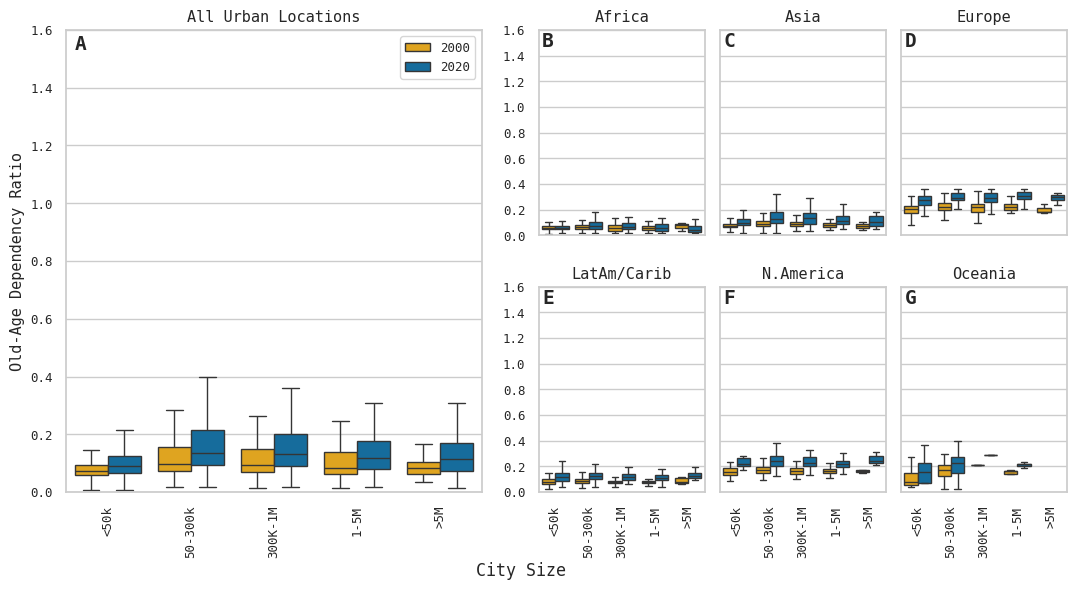

In [53]:
# Section S5: Old-Age Dependency Ratio Boxplot (main figure style)
boxplot_data = annual_metrics[['ID_UC_G0', 'year', 'old_dr', 'total_pop', 'Continent']].copy()
boxplot_data = boxplot_data[(boxplot_data['year'].isin([2000, 2020])) & (boxplot_data['Continent'] != '#N/A')]
continent_map = {
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'LatAm/Carib',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Asia',
    'Eastern and South-Eastern Asia': 'Asia',
    'Northern America': 'N.America'
}
boxplot_data['ContinentGroup'] = boxplot_data['Continent'].map(continent_map)
boxplot_data = boxplot_data.dropna(subset=['ContinentGroup'])
boxplot_data['CitySize'] = pd.Categorical(boxplot_data['total_pop'].apply(city_size_label), categories=city_size_order, ordered=True)
boxplot_data['year'] = boxplot_data['year'].astype(str)
continent_groups = ['Africa', 'Asia', 'Europe', 'LatAm/Carib', 'N.America', 'Oceania']

fig = plt.figure(figsize=(14,6))
gs = GridSpec(2, 4, figure=fig, width_ratios=[2.5, 1, 1, 1], height_ratios=[1,1], wspace=0.25, hspace=0.25)

# Big plot (double height)
ax_all = fig.add_subplot(gs[:, 0])
sns.boxplot(
    data=boxplot_data, x='CitySize', y='old_dr', hue='year', palette=boxplot_palette,
    dodge=True, linewidth=1, fliersize=0, showfliers=False, ax=ax_all
)
ax_all.set_ylabel('Old-Age Dependency Ratio', fontproperties=mono_font, fontsize=11)
ax_all.set_title('All Urban Locations', fontproperties=mono_font, fontsize=11)
ax_all.set_ylim(0, 1.6)
ax_all.set_yticks([i*0.2 for i in range(9)])
ax_all.tick_params(axis='x', rotation=90, labelsize=9)
ax_all.set_xlabel(None)
for tick in ax_all.get_yticklabels() + ax_all.get_xticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(9)
handles, labels = ax_all.get_legend_handles_labels()
ax_all.legend(handles, labels, title='', prop=mono_font, loc='upper right', fontsize=9)

# Right-hand 3x2 plots
small_axes = []
for i, cont in enumerate(continent_groups):
    row = i // 3
    col = i % 3
    ax = fig.add_subplot(gs[row, col+1])
    small_axes.append(ax)
    cont_data = boxplot_data[boxplot_data['ContinentGroup'] == cont]
    sns.boxplot(
        data=cont_data, x='CitySize', y='old_dr', hue='year', palette=boxplot_palette,
        dodge=True, linewidth=1, fliersize=0, showfliers=False, ax=ax
    )
    ax.set_title(cont, fontproperties=mono_font, fontsize=11)
    ax.set_xlabel(None)
    if row == 1:
        ax.set_xticks(range(len(city_size_order)))
        ax.set_xticklabels(city_size_order, fontproperties=mono_font, fontsize=9, rotation=90)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
    if col != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('', fontproperties=mono_font, fontsize=11)
    ax.set_ylim(0, 1.6)
    ax.set_yticks([i*0.2 for i in range(9)])
    for tick in ax.get_yticklabels() + ax.get_xticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(9)
    ax.get_legend().remove()

# Adjust horizontal gaps
for i, ax in enumerate(small_axes):
    pos = ax.get_position()
    col = i % 3
    if col == 0:
        ax.set_position([pos.x0 + 0, pos.y0, pos.width, pos.height])
    elif col == 1:
        ax.set_position([pos.x0 -0.03, pos.y0, pos.width, pos.height])
    elif col == 2:
        ax.set_position([pos.x0 - 0.06, pos.y0, pos.width, pos.height])

# Subplot letters
subplot_letters = ['A','B','C','D','E','F','G']
all_axes = [ax_all] + small_axes
for ax, letter in zip(all_axes, subplot_letters):
    ax.text(0.02, 0.99, letter, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', fontproperties=mono_font)

# Single x-axis label under figure
fig.text(0.45, -0.03, "City Size", fontproperties=mono_font, fontsize=12, ha='center')

safe_savefig(FIGURE_FOLDER / 'figs5_citysize_odr.pdf', fig)
plt.show()

# Section S6: Total Dependency Ratio

Saved: ../03_documents/02_supplement_figures/figs6_citysize_tdr.pdf


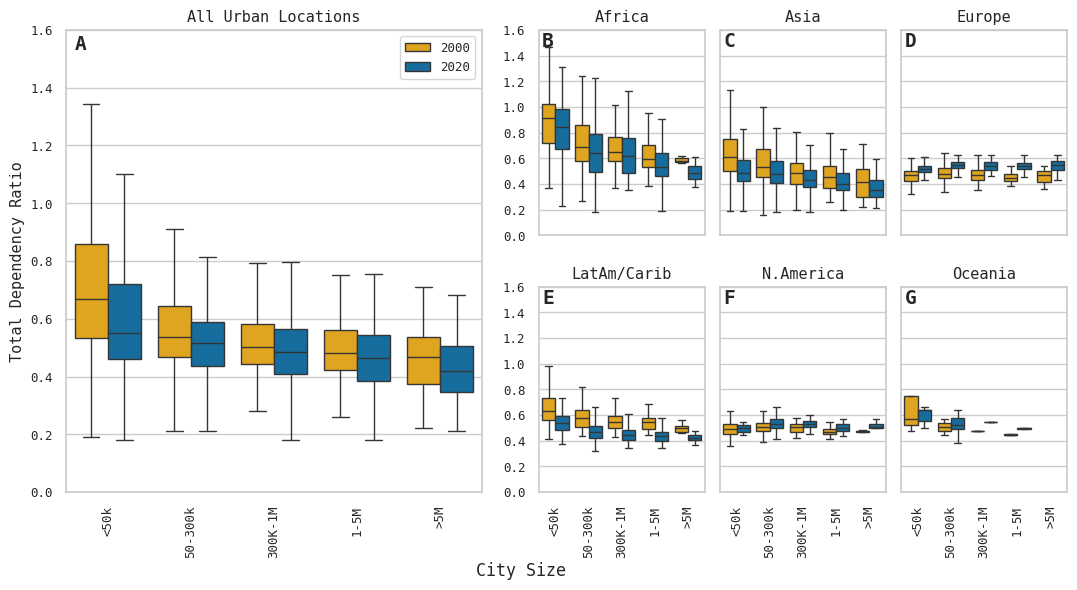

In [54]:
# Section S6: Total Dependency Ratio (main figure style)
boxplot_data = annual_metrics[['ID_UC_G0', 'year', 'total_dr', 'total_pop', 'Continent']].copy()
boxplot_data = boxplot_data[(boxplot_data['year'].isin([2000, 2020])) & (boxplot_data['Continent'] != '#N/A')]
boxplot_data['ContinentGroup'] = boxplot_data['Continent'].map(continent_map)
boxplot_data = boxplot_data.dropna(subset=['ContinentGroup'])
boxplot_data['CitySize'] = pd.Categorical(boxplot_data['total_pop'].apply(city_size_label), categories=city_size_order, ordered=True)
boxplot_data['year'] = boxplot_data['year'].astype(str)
continent_groups = ['Africa', 'Asia', 'Europe', 'LatAm/Carib', 'N.America', 'Oceania']

fig = plt.figure(figsize=(14,6))
gs = GridSpec(2, 4, figure=fig, width_ratios=[2.5, 1, 1, 1], height_ratios=[1,1], wspace=0.25, hspace=0.25)

# Big plot (double height)
ax_all = fig.add_subplot(gs[:, 0])
sns.boxplot(
    data=boxplot_data, x='CitySize', y='total_dr', hue='year', palette=boxplot_palette,
    dodge=True, linewidth=1, fliersize=0, showfliers=False, ax=ax_all
)
ax_all.set_ylabel('Total Dependency Ratio', fontproperties=mono_font, fontsize=11)
ax_all.set_title('All Urban Locations', fontproperties=mono_font, fontsize=11)
ax_all.set_ylim(0, 1.6)
ax_all.set_yticks([i*0.2 for i in range(9)])
ax_all.tick_params(axis='x', rotation=90, labelsize=9)
ax_all.set_xlabel(None)
for tick in ax_all.get_yticklabels() + ax_all.get_xticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(9)
handles, labels = ax_all.get_legend_handles_labels()
ax_all.legend(handles, labels, title='', prop=mono_font, loc='upper right', fontsize=9)

# Right-hand 3x2 plots
small_axes = []
for i, cont in enumerate(continent_groups):
    row = i // 3
    col = i % 3
    ax = fig.add_subplot(gs[row, col+1])
    small_axes.append(ax)
    cont_data = boxplot_data[boxplot_data['ContinentGroup'] == cont]
    sns.boxplot(
        data=cont_data, x='CitySize', y='total_dr', hue='year', palette=boxplot_palette,
        dodge=True, linewidth=1, fliersize=0, showfliers=False, ax=ax
    )
    ax.set_title(cont, fontproperties=mono_font, fontsize=11)
    ax.set_xlabel(None)
    if row == 1:
        ax.set_xticks(range(len(city_size_order)))
        ax.set_xticklabels(city_size_order, fontproperties=mono_font, fontsize=9, rotation=90)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
    if col != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('', fontproperties=mono_font, fontsize=11)
    ax.set_ylim(0, 1.6)
    ax.set_yticks([i*0.2 for i in range(9)])
    for tick in ax.get_yticklabels() + ax.get_xticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(9)
    ax.get_legend().remove()

# Adjust horizontal gaps
for i, ax in enumerate(small_axes):
    pos = ax.get_position()
    col = i % 3
    if col == 0:
        ax.set_position([pos.x0 + 0, pos.y0, pos.width, pos.height])
    elif col == 1:
        ax.set_position([pos.x0 -0.03, pos.y0, pos.width, pos.height])
    elif col == 2:
        ax.set_position([pos.x0 - 0.06, pos.y0, pos.width, pos.height])

# Subplot letters
subplot_letters = ['A','B','C','D','E','F','G']
all_axes = [ax_all] + small_axes
for ax, letter in zip(all_axes, subplot_letters):
    ax.text(0.02, 0.99, letter, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', fontproperties=mono_font)

# Single x-axis label under figure
fig.text(0.45, -0.03, "City Size", fontproperties=mono_font, fontsize=12, ha='center')

safe_savefig(FIGURE_FOLDER / 'figs6_citysize_tdr.pdf', fig)
plt.show()

# Section S7: Natural Growth vs. Migration by Continent

This section visualizes the relationship between natural growth and migration for urban areas, by continent and city size, using both scatter and stacked bar plots.

Saved: ../03_documents/02_supplement_figures/figs7_migration_continent.pdf


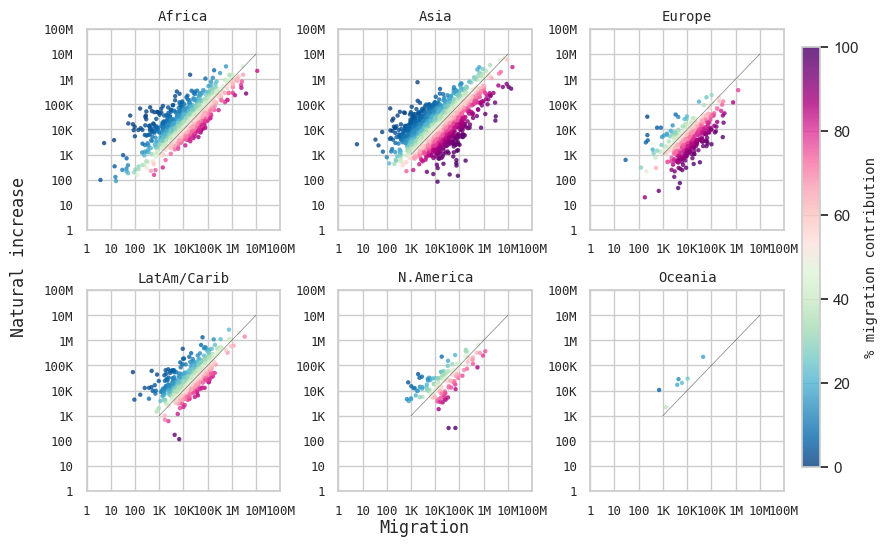

In [55]:
# Prepare data for migration vs. natural growth plots
scatter_data = change_data.copy()
scatter_data = scatter_data[(scatter_data['total_migration'] > 0) & (scatter_data['natural_change'] > 0)].copy()
continent_map = {
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'LatAm/Carib',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Asia',
    'Eastern and South-Eastern Asia': 'Asia',
    'Northern America': 'N.America'
}
scatter_data['ContinentGroup'] = scatter_data['Continent'].map(continent_map)
scatter_data = scatter_data.dropna(subset=['ContinentGroup'])
scatter_data['CitySize'] = pd.Categorical(scatter_data['total_pop_2020'].apply(city_size_label), categories=city_size_order, ordered=True)

# Colors for migration contribution
nat_colors = ['#084081','#0868ac','#2b8cbe','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5','#e0f3db']
mig_colors = ['#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a']
full_colors = nat_colors + mig_colors
migration_cmap = mcolors.LinearSegmentedColormap.from_list("migration", full_colors)
norm_migration = mcolors.Normalize(0, 100)

continent_groups = ['Africa', 'Asia', 'Europe', 'LatAm/Carib', 'N.America', 'Oceania']
n_cont = len(continent_groups)
cols = 3
rows = int(np.ceil(n_cont / cols))

fig = plt.figure(figsize=(cols*3, rows*3))
gs = GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.3)
lims = [1e3, 1e7]
ticks = [1,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8]
labels = ["1","10","100","1K","10K","100K","1M","10M","100M"]

for i, cont in enumerate(continent_groups):
    row = i // cols
    col = i % cols
    ax = fig.add_subplot(gs[row, col])
    df = scatter_data[scatter_data['ContinentGroup'] == cont]
    sc = ax.scatter(
        df['total_migration'],
        df['natural_change'],
        c=df['perc_from_migration'],
        cmap=migration_cmap,
        norm=norm_migration,
        s=10,
        edgecolor="black",
        linewidth=0.0001,
        alpha=0.8
    )
    ax.plot(lims, lims, color="black", linewidth=0.5, alpha=0.5)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, fontproperties=mono_font)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels, fontproperties=mono_font)
    ax.set_title(cont, fontproperties=mono_font, fontsize=10)

fig.text(0.5, 0.04, "Migration", ha='center', fontproperties=mono_font, fontsize=12)
fig.text(0.04, 0.5, "Natural increase", va='center', rotation='vertical', fontproperties=mono_font, fontsize=12)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(sc, cax=cbar_ax)
cbar.set_label("% migration contribution", fontproperties=mono_font, fontsize=10)
safe_savefig(FIGURE_FOLDER / 'figs7_migration_continent.pdf', fig)
plt.show()


# Section S10.2 - Main manuscript figures with dynamic boundaries

This section reproduces the main manuscript figures using dynamic urban boundaries, for comparison with the static boundary results above.

In [56]:
# Load dynamic boundary data and world shapefile
import pandas as pd
import geopandas as gpd
from pathlib import Path

# Ensure data folder variable is available
if 'DATA_FOLDER' not in globals():
    DATA_FOLDER = Path('../01_data/')
if 'FIGURE_FOLDER' not in globals():
    FIGURE_FOLDER = Path('../04_documents/02_supplement_figures/')

annual_metrics_dynamic = pd.read_csv(DATA_FOLDER / '04_final_demographic_data/02_dynamic_boundaries/gudd_annual_metrics_dynamic_boundaries.csv')
change_data_dynamic = pd.read_csv(DATA_FOLDER / '04_final_demographic_data/02_dynamic_boundaries/gudd_change_2000_2020_dynamic_boundaries.csv')

# Always reload world for this section
global world
globals()['world'] = gpd.read_file(DATA_FOLDER / '02_auxiliary_data/03_mapping/ne_50m_admin_0_countries.shp')

/tmp/ipykernel_42329/3681113983.py:12: DtypeWarning: Columns (0: Name, 1: Country, 2: Continent, 3: Development) have mixed types. Specify dtype option on import or set low_memory=False.
  annual_metrics_dynamic = pd.read_csv(DATA_FOLDER / '04_final_demographic_data/02_dynamic_boundaries/gudd_annual_metrics_dynamic_boundaries.csv')


In [57]:
# Limit annual metrics to only include 2020 for plotting
df_2020 = annual_metrics_dynamic[(annual_metrics_dynamic['YearOfBirth'] <= 2000) &
                                 (annual_metrics_dynamic['YearOfDeath'] >= 2020) &
                                 (annual_metrics_dynamic['year'] == 2020)].copy()
change_data_dynamic = change_data_dynamic[(change_data_dynamic['YearOfBirth'] <= 2000) &
                                          (change_data_dynamic['YearOfDeath'] >= 2020)].copy()


In [58]:
# Set up colormaps for dependency ratios and changes
import matplotlib.colors as mcolors

colors_dr = [
    "#053061", "#2166AC", "#4393C3", "#92C5DE",
    "#D1E5F0", "#F4A582", "#D6604D", "#B2182B", "#67001F"
]
colors_delta = [
    "#40004B", "#762A83", "#9970AB", "#C2A5CF", "#E7D4E8",
    "#D9F0D3", "#A6DBA0", "#5AAE61", "#1B7837", "#00441B"
]
cmap_dr = mcolors.LinearSegmentedColormap.from_list("dr", colors_dr)
cmap_delta = mcolors.LinearSegmentedColormap.from_list("delta", colors_delta)


Saved: ../03_documents/02_supplement_figures/figs10_1_udr_map.pdf


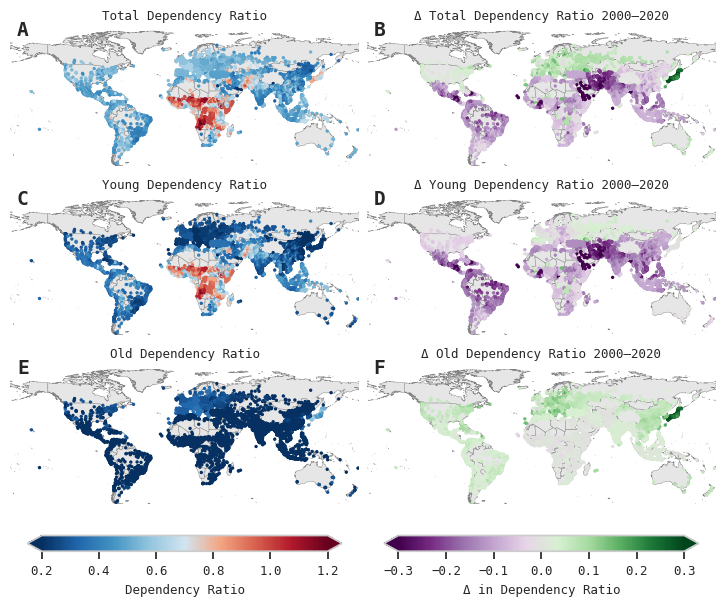

In [72]:
# Section S10.1 - Dynamic Boundaries: Main Dependency Ratio Maps (Styled Like Main Figure 1)
# This cell mirrors the style and logic of Figure 1 in the main figures notebook, but uses dynamic boundaries data.
fig, axes = plt.subplots(3, 2, figsize=(7.1, 6), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, hspace=0.02, wspace=0.02)
subplot_letters = ["A", "B", "C", "D", "E", "F"]

# Plot each map with fixed vmin/vmax and colorbars with 'extend' for consistency
sc1, norm1 = plot_map(axes[0,0], df_2020, "total_dr", cmap_dr, 0.2, 1.2, "Total Dependency Ratio", letter=None)
sc2, norm2 = plot_map(axes[0,1], change_data_dynamic, "total_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Total Dependency Ratio 2000–2020", letter=None)
sc3, norm3 = plot_map(axes[1,0], df_2020, "young_dr", cmap_dr, 0.2, 1.2, "Young Dependency Ratio", letter=None)
sc4, norm4 = plot_map(axes[1,1], change_data_dynamic, "young_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Young Dependency Ratio 2000–2020", letter=None)
sc5, norm5 = plot_map(axes[2,0], df_2020, "old_dr", cmap_dr, 0.2, 1.2, "Old Dependency Ratio", letter=None)
sc6, norm6 = plot_map(axes[2,1], change_data_dynamic, "old_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Old Dependency Ratio 2000–2020", letter=None)

# Subplot letters
letter_y = 0.9
for ax, letter in zip(axes.flat, subplot_letters):
    ax.text(0.02, letter_y, letter, transform=ax.transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="bottom", ha="left", zorder=3)

# Colorbars (with 'extend' for both)
cbar1 = fig.colorbar(plt.cm.ScalarMappable(norm=norm1, cmap=cmap_dr), ax=axes[:,0], orientation="horizontal", fraction=0.04, pad=0.06, shrink=0.9, extend='both')
cbar2 = fig.colorbar(plt.cm.ScalarMappable(norm=norm2, cmap=cmap_delta), ax=axes[:,1], orientation="horizontal", fraction=0.04, pad=0.06, shrink=0.9, extend='both')
for cbar, label in zip([cbar1, cbar2], ["Dependency Ratio", "Δ in Dependency Ratio"]):
    cbar.ax.set_xlabel(label, fontproperties=mono_font)
    for tick in cbar.ax.get_xticklabels():
        tick.set_fontproperties(mono_font)

output_file = FIGURE_FOLDER / 'figs10_1_udr_map.pdf'
safe_savefig(output_file, fig)
plt.show()

Saved: ../03_documents/02_supplement_figures/figs10_3_citysize_ydr_dynamic.pdf


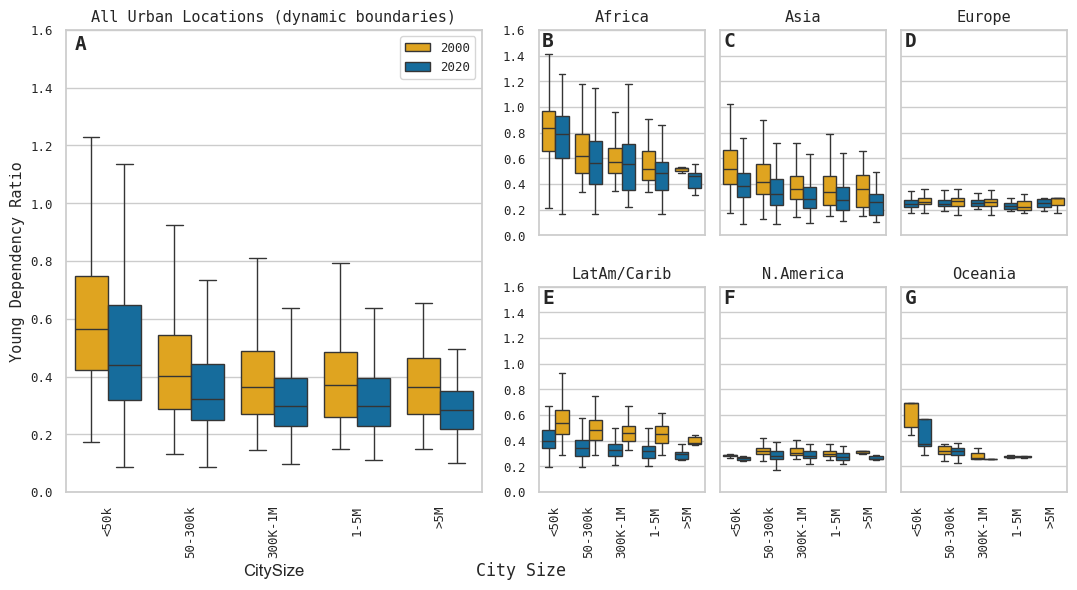

In [70]:
# Section S10.3 - Dynamic Boundaries: Young Dependency Ratio Boxplots (styled like main Figure 3)
# Use `annual_metrics_dynamic` (filtered to 2000/2020) to create boxplots by city size and continent
boxplot_data_dyn = annual_metrics_dynamic[[
    'ID_UC_G0', 'year', 'young_dr', 'total_pop', 'Continent'
]].copy()
boxplot_data_dyn = boxplot_data_dyn[(boxplot_data_dyn['year'].isin([2000, 2020])) & (boxplot_data_dyn['Continent'] != '#N/A')]
boxplot_data_dyn['ContinentGroup'] = boxplot_data_dyn['Continent'].map({
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'LatAm/Carib',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Asia',
    'Eastern and South-Eastern Asia': 'Asia',
    'Northern America': 'N.America'
})
boxplot_data_dyn = boxplot_data_dyn.dropna(subset=['ContinentGroup'])
boxplot_data_dyn['CitySize'] = pd.Categorical(boxplot_data_dyn['total_pop'].apply(city_size_label), categories=city_size_order, ordered=True)
boxplot_data_dyn['year'] = boxplot_data_dyn['year'].astype(str)

fig3_dyn = plt.figure(figsize=(14,6))
gs3 = GridSpec(2, 4, figure=fig3_dyn, width_ratios=[2.5, 1, 1, 1], height_ratios=[1,1], wspace=0.25, hspace=0.25)

# Big plot
ax_big = fig3_dyn.add_subplot(gs3[:,0])
sns.boxplot(data=boxplot_data_dyn, x='CitySize', y='young_dr', hue='year', palette=boxplot_palette, dodge=True, linewidth=1, fliersize=0, showfliers=False, ax=ax_big)
ax_big.set_ylabel('Young Dependency Ratio', fontproperties=mono_font, fontsize=11)
ax_big.set_title('All Urban Locations (dynamic boundaries)', fontproperties=mono_font, fontsize=11)
ax_big.set_ylim(0,1.6)
ax_big.set_yticks([i*0.2 for i in range(9)])
ax_big.tick_params(axis='x', rotation=90, labelsize=9)
for tick in ax_big.get_yticklabels() + ax_big.get_xticklabels():
    tick.set_fontproperties(mono_font)
    tick.set_fontsize(9)
handles, labels = ax_big.get_legend_handles_labels()
ax_big.legend(handles, labels, title='', prop=mono_font, loc='upper right', fontsize=9)

# Right-hand small plots
continent_groups = ['Africa', 'Asia', 'Europe', 'LatAm/Carib', 'N.America', 'Oceania']
small_axes = []
for i, cont in enumerate(continent_groups):
    row = i // 3
    col = i % 3
    ax = fig3_dyn.add_subplot(gs3[row, col+1])
    small_axes.append(ax)
    cont_data = boxplot_data_dyn[boxplot_data_dyn['ContinentGroup'] == cont]
    sns.boxplot(data=cont_data, x='CitySize', y='young_dr', hue='year', palette=boxplot_palette, dodge=True, linewidth=1, fliersize=0, showfliers=False, ax=ax)
    ax.set_title(cont, fontproperties=mono_font, fontsize=11)
    ax.set_xlabel(None)
    if row == 1:
        ax.set_xticks(range(len(city_size_order)))
        ax.set_xticklabels(city_size_order, fontproperties=mono_font, fontsize=9, rotation=90)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])
    if col != 0:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('', fontproperties=mono_font, fontsize=11)
    ax.set_ylim(0,1.6)
    ax.set_yticks([i*0.2 for i in range(9)])
    for tick in ax.get_yticklabels() + ax.get_xticklabels():
        tick.set_fontproperties(mono_font)
        tick.set_fontsize(9)
    ax.get_legend().remove()

# Adjustments and labels
for i, ax in enumerate(small_axes):
    pos = ax.get_position()
    col = i % 3
    if col == 0:
        ax.set_position([pos.x0 + 0, pos.y0, pos.width, pos.height])
    elif col == 1:
        ax.set_position([pos.x0 -0.03, pos.y0, pos.width, pos.height])
    elif col == 2:
        ax.set_position([pos.x0 - 0.06, pos.y0, pos.width, pos.height])

subplot_letters = ['A','B','C','D','E','F','G']
all_axes = [ax_big] + small_axes
for ax, letter in zip(all_axes, subplot_letters):
    ax.text(0.02, 0.99, letter, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', fontproperties=mono_font)

fig3_dyn.text(0.45, -0.03, 'City Size', fontproperties=mono_font, fontsize=12, ha='center')

safe_savefig(FIGURE_FOLDER / 'figs10_3_citysize_ydr_dynamic.pdf', fig3_dyn)
plt.show()


Saved: ../03_documents/02_supplement_figures/figs10_2_usr_map_dynamic.pdf


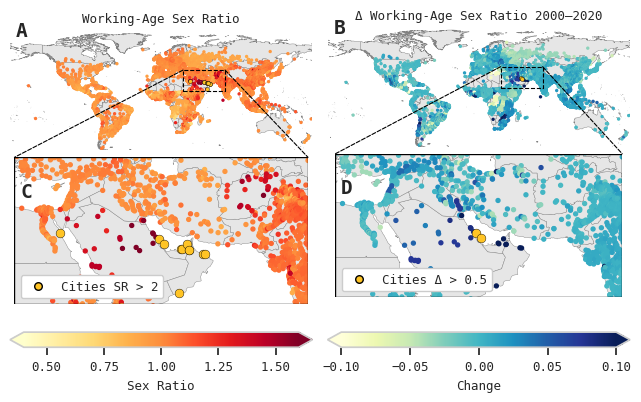

In [71]:
# Section S10.2 - Dynamic Boundaries: Working-Age Sex Ratio (styled like main Figure 2)
# Uses `annual_metrics_dynamic` and `change_data_dynamic` loaded above
highlight = change_data_dynamic[change_data_dynamic["working_sr_Delta"] > 0.5]
highlight_sr = df_2020[df_2020["working_sr"] > 2]

fig2_dyn, axes = plt.subplots(2, 2, figsize=(8, 4.5), gridspec_kw={'hspace':0.05, 'wspace':0.05})

# Main maps
sc1, _ = plot_map(axes[0,0], df_2020, "working_sr", cmap_sr, 0.4, 1.6, "Working-Age Sex Ratio", region_box=True, highlight_points=highlight_sr)
vmin_delta, vmax_delta = -0.1, 0.1
sc2, _ = plot_map(axes[0,1], change_data_dynamic, "working_sr_Delta", cmap_delta_sr, vmin_delta, vmax_delta, "Δ Working-Age Sex Ratio 2000–2020", region_box=True, highlight_points=highlight)
# Inset maps
sc3, _ = plot_map(axes[1,0], df_2020, "working_sr", cmap_sr, 0.4, 1.6, "", inset=True, inset_box=True, highlight_points=highlight_sr)
sc4, _ = plot_map(axes[1,1], change_data_dynamic, "working_sr_Delta", cmap_delta_sr, vmin_delta, vmax_delta, "", inset=True, inset_box=True, highlight_points=highlight)

# Subplot letters
axes[0,0].text(0.02, 0.9, "A", transform=axes[0,0].transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="bottom", ha="left", zorder=3)
axes[0,1].text(0.02, 0.9, "B", transform=axes[0,1].transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="bottom", ha="left", zorder=3)
axes[1,0].text(0.02, 0.7, "C", transform=axes[1,0].transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="bottom", ha="left", zorder=3)
axes[1,1].text(0.02, 0.7, "D", transform=axes[1,1].transAxes, fontproperties=mono_font, fontsize=14, fontweight="bold", va="bottom", ha="left", zorder=3)

# Connectors
connect_axes(fig2_dyn, axes[0,0], axes[1,0])
connect_axes(fig2_dyn, axes[0,1], axes[1,1])

# Colorbars
cbar1 = fig2_dyn.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(0.4, 1.6), cmap=cmap_sr),
    ax=[axes[0,0], axes[1,0]], orientation="horizontal", fraction=0.05, pad=0.08, extend='both')
cbar1.set_label("Sex Ratio", fontproperties=mono_font)
for t in cbar1.ax.get_xticklabels(): t.set_fontproperties(mono_font)
cbar2 = fig2_dyn.colorbar(
    plt.cm.ScalarMappable(norm=plt.Normalize(vmin_delta, vmax_delta), cmap=cmap_delta_sr),
    ax=[axes[0,1], axes[1,1]], orientation="horizontal", fraction=0.05, pad=0.1, extend='both')
cbar2.set_label("Change", fontproperties=mono_font)
for t in cbar2.ax.get_xticklabels(): t.set_fontproperties(mono_font)

# Legends for highlights
from matplotlib.lines import Line2D
legend_marker_size = 30
highlight_marker = Line2D([0], [0], marker='o', color='w', label='Cities SR > 2', markerfacecolor='#ffc425', markeredgecolor='black', markersize=np.sqrt(legend_marker_size), linewidth=0.15)
highlight_delta_marker = Line2D([0], [0], marker='o', color='w', label='Cities Δ > 0.5', markerfacecolor='#ffc425', markeredgecolor='black', markersize=np.sqrt(legend_marker_size), linewidth=0.15)
if len(highlight_sr):
    axes[1,0].legend(handles=[highlight_marker], frameon=True, fontsize=8, prop=mono_font, loc='lower left', markerscale=1.0, facecolor='white', framealpha=1.0)
if len(highlight):
    axes[1,1].legend(handles=[highlight_delta_marker], frameon=True, fontsize=8, prop=mono_font, loc='lower left', markerscale=1.0, facecolor='white', framealpha=1.0)

safe_savefig(FIGURE_FOLDER / 'figs10_2_usr_map_dynamic.pdf', fig2_dyn)
plt.show()


Saved: ../03_documents/02_supplement_figures/figs10_4_migration_dynamic.pdf


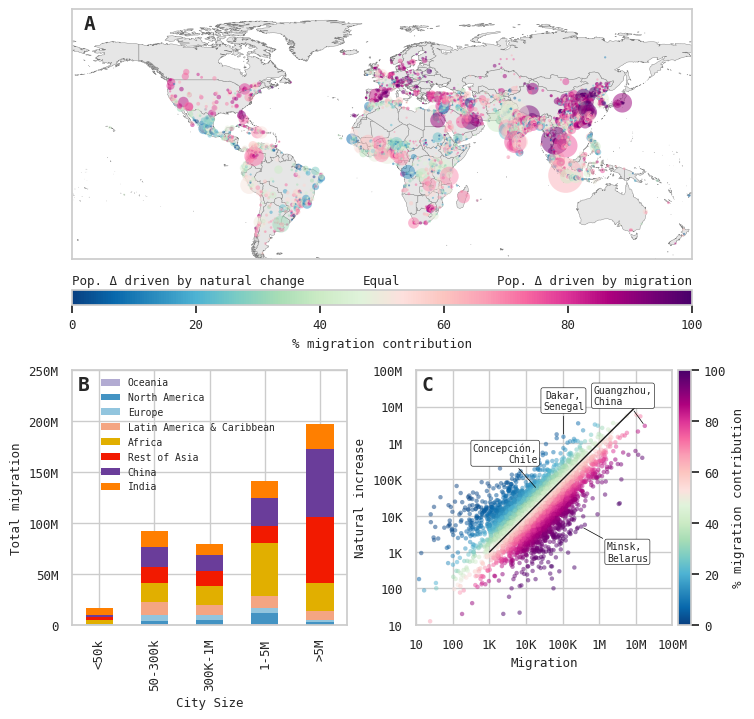

In [78]:
# Section S10.4 - Dynamic Boundaries: Migration vs Natural Change (styled like main Figure 4)
# Uses `change_data_dynamic` and the canonical figure style from the cleaned notebook
# Ensure continent mapping exists (fallback if not defined earlier)
continent_map_mig = {
    'Oceania': 'Oceania',
    'Australia and New Zealand': 'Oceania',
    'Latin America and the Caribbean': 'Latin America and the Caribbean',
    'Sub-Saharan Africa': 'Africa',
    'Northern Africa and Western Asia': 'Africa',
    'Europe': 'Europe',
    'Central and Southern Asia': 'Rest of Asia',
    'Eastern and South-Eastern Asia': 'Rest of Asia',
    'Northern America': 'North America'
}

migration_map_data_dyn = change_data_dynamic.copy()
migration_map_data_dyn = migration_map_data_dyn[(migration_map_data_dyn["total_migration"] > 0) & (migration_map_data_dyn["natural_change"] > 0)].copy()
migration_map_data_dyn["Continent"] = migration_map_data_dyn["Continent"].map(continent_map_mig)
migration_map_data_dyn.loc[migration_map_data_dyn["Country"]=="China","Continent"]="China"
migration_map_data_dyn.loc[migration_map_data_dyn["Country"]=="India","Continent"]="India"
migration_map_data_dyn["CitySize"] = pd.Categorical(
    migration_map_data_dyn["total_pop_2020"].apply(city_size_label),
    categories=city_size_order, ordered=True
)

# Stacked bar data (recompute on dynamic dataset)
# Ensure continent_order exists (fallback)
continent_order = ["Oceania", "North America", "Europe", "Latin America and the Caribbean", "Africa", "Rest of Asia", "China", "India"]
stacked_data_dyn = migration_map_data_dyn.groupby(["CitySize","Continent"],as_index=False)["total_migration"].sum()
stacked_data_dyn = stacked_data_dyn[stacked_data_dyn["Continent"].isin(continent_order)]
stacked_pivot_dyn = stacked_data_dyn.pivot_table(index="CitySize", columns="Continent", values="total_migration", fill_value=0).reindex(index=city_size_order,columns=continent_order)

# Reuse label_specs from main figure; fall back to an inline small set if missing
try:
    _ = label_specs
except NameError:
    label_specs = {
        ("Guangzhou", "China"): {"xmult": 0.04, "ymult": 10.0, "ha": "left", "va": "bottom"},
        ("Dakar", "Senegal"): {"xmult": 1.0, "ymult": 5.0, "ha": "center", "va": "bottom"},
        ("Minsk", "Belarus"): {"xmult": 5.0, "ymult": 0.4, "ha": "left", "va": "top"},
        ("Concepción", "Chile"): {"xmult": 1, "ymult": 20.0, "ha": "right", "va": "top"},
    }

fig4_dyn = plt.figure(figsize=(8,8))
gs_dyn = GridSpec(2,2, height_ratios=[1.2,1], hspace=0.2, wspace=0.25)
subplot_labels = ['A','B','C']

# PANEL A - Map (dynamic)
ax_map = fig4_dyn.add_subplot(gs_dyn[0,:])
sizes = np.interp(migration_map_data_dyn["total_pop_Delta"], (migration_map_data_dyn["total_pop_Delta"].min(), migration_map_data_dyn["total_pop_Delta"].max()), (2,800))
sc_map = ax_map.scatter(
    migration_map_data_dyn.longitude, migration_map_data_dyn.latitude,
    c=migration_map_data_dyn.perc_from_migration, cmap=migration_cmap, norm=norm_migration,
    s=sizes, edgecolor="black", linewidth=0, alpha=0.5, zorder=2)
world.plot(ax=ax_map, color="#E6E6E6", edgecolor="0.5", linewidth=0.3, zorder=1)
ax_map.set_xlim(-180,180)
ax_map.set_ylim(-55,90)
ax_map.set_xticks([])
ax_map.set_yticks([])
sm_map = plt.cm.ScalarMappable(cmap=migration_cmap, norm=norm_migration)
sm_map.set_array([])
cbar = fig4_dyn.colorbar(sm_map, ax=ax_map, orientation="horizontal", fraction=0.08, pad=0.10, aspect=40)
cbar.set_label("% migration contribution", fontproperties=mono_font)
for tick in cbar.ax.get_xticklabels(): tick.set_fontproperties(mono_font)
cbar.ax.text(0.0, 1.2, "Pop. Δ driven by natural change", ha='left', va='bottom', transform=cbar.ax.transAxes, fontproperties=mono_font)
cbar.ax.text(0.5, 1.2, "Equal", ha='center', va='bottom', transform=cbar.ax.transAxes, fontproperties=mono_font)
cbar.ax.text(1.0, 1.2, "Pop. Δ driven by migration", ha='right', va='bottom', transform=cbar.ax.transAxes, fontproperties=mono_font)

# PANEL B - Stacked bar (dynamic)
ax_bar = fig4_dyn.add_subplot(gs_dyn[1,0])
bar_colors = [
    '#B2ABD2', '#4393C3', '#92C5DE', '#F4A582', '#E1AF00', '#F21A00', '#6A3D9A', '#FF7F00',
]
stacked_pivot_dyn.plot(kind="bar", stacked=True, ax=ax_bar, linewidth=0, color=bar_colors)
ax_bar.set_ylabel("Total migration", fontproperties=mono_font)
ax_bar.set_xlabel("City Size", fontproperties=mono_font)
yticks = ax_bar.get_yticks()
ax_bar.set_yticks(yticks)
ax_bar.set_yticklabels([f"{int(y/1e6)}M" if y>0 else "0" for y in yticks], fontproperties=mono_font)
for tick in ax_bar.get_xticklabels(): tick.set_fontproperties(mono_font)
handles, legend_labels = ax_bar.get_legend_handles_labels()
legend_labels = ["Latin America & Caribbean" if lab == "Latin America and the Caribbean" else lab for lab in legend_labels]
fig4_dyn.legend(handles, legend_labels, prop=legend_font, frameon=False, loc="upper left", bbox_to_anchor=(0.15,0.43))
ax_bar.get_legend().remove()

# PANEL C - Scatter (dynamic)
ax_scatter = fig4_dyn.add_subplot(gs_dyn[1,1])
sc = ax_scatter.scatter(
    migration_map_data_dyn["total_migration"], migration_map_data_dyn["natural_change"],
    c=migration_map_data_dyn["perc_from_migration"], cmap=migration_cmap, norm=norm_migration,
    s=10, edgecolor="black", linewidth=0.01, alpha=0.5)
ax_scatter.set_xscale("log")
ax_scatter.set_yscale("log")
lims = [1e3,1e7]
ax_scatter.set_xlim(lims)
ax_scatter.set_ylim(lims)
ax_scatter.plot(lims, lims, linestyle="-", linewidth=1, color="k", alpha=1.0, zorder=1)
ticks = [10,1e2,1e3,1e4,1e5,1e6,1e7,1e8]
labels = ["10","100","1K","10K","100K","1M","10M","100M"]
ax_scatter.set_xticks(ticks)
ax_scatter.set_xticklabels(labels,fontproperties=mono_font)
ax_scatter.set_yticks(ticks)
ax_scatter.set_yticklabels(labels,fontproperties=mono_font)
ax_scatter.set_xlabel("Migration",fontproperties=mono_font)
ax_scatter.set_ylabel("Natural increase",fontproperties=mono_font)
sm_scatter = plt.cm.ScalarMappable(cmap=migration_cmap, norm=norm_migration)
sm_scatter.set_array([])
cbar2 = fig4_dyn.colorbar(sm_scatter, ax=ax_scatter, fraction=0.05, pad=0.02)
for tick in cbar2.ax.get_yticklabels(): tick.set_fontproperties(mono_font)
for tick in cbar2.ax.get_xticklabels(): tick.set_fontproperties(mono_font)
cbar2.set_label("% migration contribution", fontproperties=mono_font)

# Label selected cities
for (name, country), spec in label_specs.items():
    row = migration_map_data_dyn[(migration_map_data_dyn["Name"] == name) & (migration_map_data_dyn["Country"] == country)]
    if row.empty: continue
    x = row["total_migration"].values[0]
    y = row["natural_change"].values[0]
    x_text = np.clip(x * spec["xmult"], lims[0], lims[1])
    y_text = np.clip(y * spec["ymult"], lims[0], lims[1])
    label_text = f"{name},\n{country}"
    ax_scatter.annotate(
        label_text, xy=(x, y), xytext=(x_text, y_text), textcoords="data",
        arrowprops=dict(arrowstyle="-", linewidth=0.5, color="black"),
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", linewidth=0.4),
        fontproperties=label_font, ha=spec["ha"], va=spec["va"])

# Panel labels
for ax, label in zip([ax_map, ax_bar, ax_scatter], subplot_labels):
    ax.text(0.02, 0.98, label, transform=ax.transAxes, fontsize=14, fontweight='bold', va='top', ha='left', fontproperties=mono_font)

# Save
out_path = FIGURE_FOLDER / 'figs10_4_migration_dynamic.pdf'
safe_savefig(out_path, fig4_dyn)
plt.show()


# Section S12 - Figure 1 with independent colorbars

This section provides the main dependency ratio maps with independent colorbars for each subplot, as in the supplement.

Saved: ../03_documents/02_supplement_figures/figs12_udr_map_individual_cbar.pdf


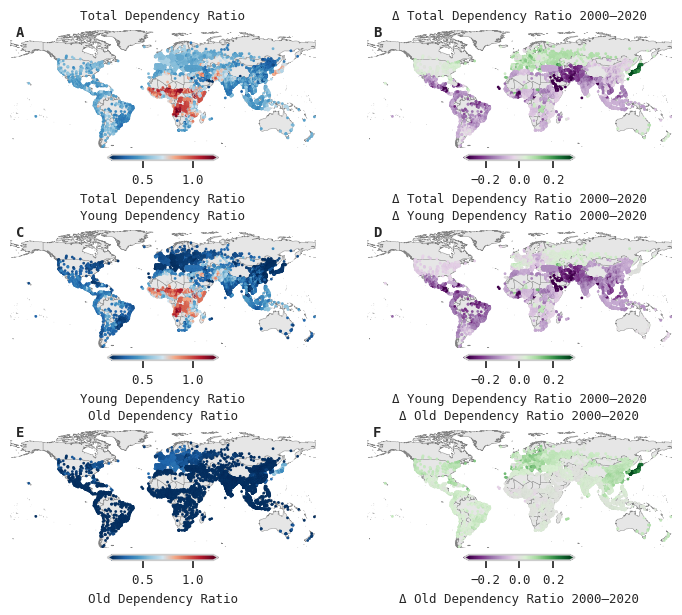

In [79]:
# Section S12 - Dynamic Boundaries: Main Dependency Ratio Maps with Independent Colorbars (Styled Like Main Figure 1, but with dynamic boundaries)
fig, axes = plt.subplots(3, 2, figsize=(7.1, 6), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, hspace=0.02, wspace=0.02)
plots = [
    (axes[0,0], df_2020, "total_dr", cmap_dr, "Total Dependency Ratio", "A"),
    (axes[0,1], change_data_dynamic, "total_dr_Delta", cmap_delta, "Δ Total Dependency Ratio 2000–2020", "B"),
    (axes[1,0], df_2020, "young_dr", cmap_dr, "Young Dependency Ratio", "C"),
    (axes[1,1], change_data_dynamic, "young_dr_Delta", cmap_delta, "Δ Young Dependency Ratio 2000–2020", "D"),
    (axes[2,0], df_2020, "old_dr", cmap_dr, "Old Dependency Ratio", "E"),
    (axes[2,1], change_data_dynamic, "old_dr_Delta", cmap_delta, "Δ Old Dependency Ratio 2000–2020", "F")
]

def plot_map_individual(ax, data, column, cmap, title, letter=None):
    world.plot(
        ax=ax,
        color="#E6E6E6",
        edgecolor="0.5",
        linewidth=0.3,
        zorder=1
    )
    vmin, vmax = data[column].min(), data[column].max()
    # Use fixed vmin/vmax for consistency with main figures
    if 'Delta' in column:
        vmin, vmax = -0.3, 0.3
    else:
        vmin, vmax = 0.2, 1.2
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    rgba_colors = cmap(norm(data[column]))
    edge_colors = np.array([darken_color(c[:3], 0.6) + (c[3],) for c in rgba_colors])
    sc = ax.scatter(
        data["longitude"],
        data["latitude"],
        c=rgba_colors,
        s=4,
        edgecolor=edge_colors,
        linewidth=0.0005,
        zorder=2
    )
    ax.set_xlim(-180, 180)
    ax.set_ylim(-55, 90)
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(True, linestyle="--", linewidth=0.3, alpha=1)
    ax.set_title(title, fontproperties=mono_font, fontsize=9, pad=4)
    if letter:
        ax.text(0.02, 1, letter, transform=ax.transAxes, fontproperties=mono_font, fontsize=10, fontweight="bold", va="top", ha="left", zorder=3)
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        ax=ax,
        orientation="horizontal",
        fraction=0.045,
        pad=0.05,
        extend='both'
    )
    cbar.ax.tick_params(labelsize=7)
    cbar.ax.set_xlabel(title, fontproperties=mono_font)
    for tick in cbar.ax.get_xticklabels():
        tick.set_fontproperties(mono_font)
    return sc, norm, cbar

for ax, data, col, cmap, title, letter in plots:
    plot_map_individual(ax, data, col, cmap, title, letter=letter)

output_file = FIGURE_FOLDER / 'figs12_udr_map_individual_cbar.pdf'
safe_savefig(output_file, fig)
plt.show()

Saved: ../03_documents/02_supplement_figures/figs10_1_udr_map.pdf


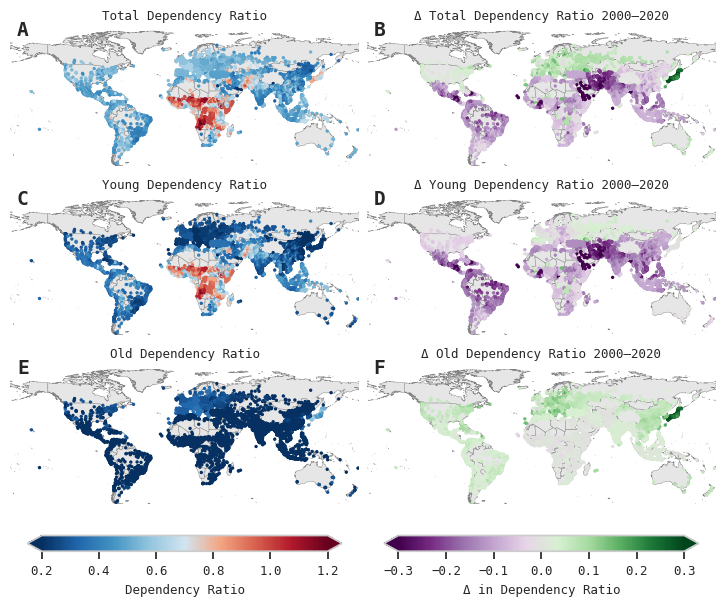

In [82]:
# Section S10.1 - Dynamic Boundaries: Main Dependency Ratio Maps (canonical symbology)
fig1_dyn, axes = plt.subplots(3, 2, figsize=(7.1, 6), constrained_layout=True)
fig1_dyn.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, hspace=0.02, wspace=0.02)
# Plot each map using canonical `plot_map` to ensure matching symbology
sc1, norm1 = plot_map(axes[0,0], df_2020, "total_dr", cmap_dr, 0.2, 1.2, "Total Dependency Ratio", letter=None)
sc2, norm2 = plot_map(axes[0,1], change_data_dynamic, "total_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Total Dependency Ratio 2000–2020", letter=None)
sc3, norm3 = plot_map(axes[1,0], df_2020, "young_dr", cmap_dr, 0.2, 1.2, "Young Dependency Ratio", letter=None)
sc4, norm4 = plot_map(axes[1,1], change_data_dynamic, "young_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Young Dependency Ratio 2000–2020", letter=None)
sc5, norm5 = plot_map(axes[2,0], df_2020, "old_dr", cmap_dr, 0.2, 1.2, "Old Dependency Ratio", letter=None)
sc6, norm6 = plot_map(axes[2,1], change_data_dynamic, "old_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Old Dependency Ratio 2000–2020", letter=None)
# Subplot letters (slightly higher)
for ax, letter in zip(axes.flat, ['A','B','C','D','E','F']):
    ax.text(0.02, 0.9, letter, transform=ax.transAxes, fontproperties=mono_font, fontsize=14, fontweight='bold', va='bottom', ha='left', zorder=3)
# Colorbars (canonical: shared per column, extended)
cbar1 = fig1_dyn.colorbar(plt.cm.ScalarMappable(norm=norm1, cmap=cmap_dr), ax=axes[:,0], orientation='horizontal', fraction=0.04, pad=0.06, shrink=0.9, extend='both')
cbar2 = fig1_dyn.colorbar(plt.cm.ScalarMappable(norm=norm2, cmap=cmap_delta), ax=axes[:,1], orientation='horizontal', fraction=0.04, pad=0.06, shrink=0.9, extend='both')
for cbar, label in zip([cbar1, cbar2], ['Dependency Ratio', 'Δ in Dependency Ratio']):
    cbar.ax.set_xlabel(label, fontproperties=mono_font)
    for tick in cbar.ax.get_xticklabels():
        tick.set_fontproperties(mono_font)
# Save (overwrite existing S10.1 output to keep filenames consistent)
out_path = FIGURE_FOLDER / 'figs10_1_udr_map.pdf'
safe_savefig(out_path, fig1_dyn)
plt.show()

Saved: ../03_documents/02_supplement_figures/figs12_udr_map_individual_cbar.pdf


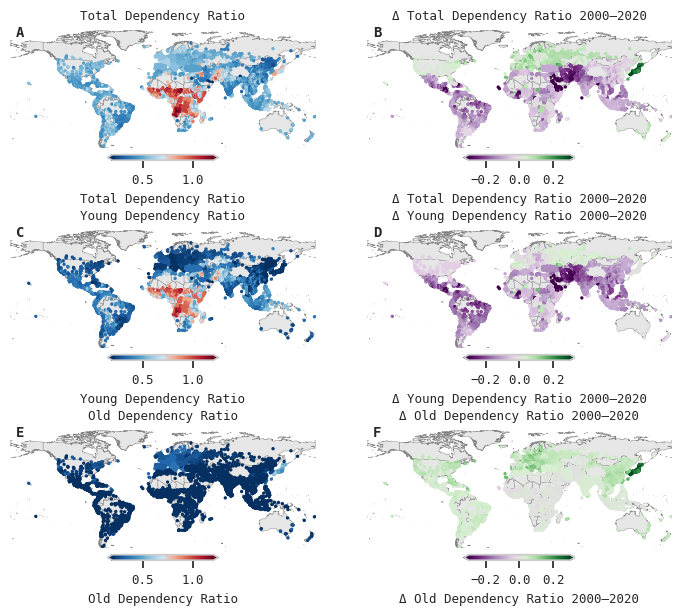

In [81]:
# Section S12 - Dynamic Boundaries: Main Dependency Ratio Maps with Independent Colorbars (canonical symbology)
fig, axes = plt.subplots(3, 2, figsize=(7.1, 6), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, hspace=0.02, wspace=0.02)
plots = [
    (axes[0,0], df_2020, "total_dr", cmap_dr, 0.2, 1.2, "Total Dependency Ratio", "A"),
    (axes[0,1], change_data_dynamic, "total_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Total Dependency Ratio 2000–2020", "B"),
    (axes[1,0], df_2020, "young_dr", cmap_dr, 0.2, 1.2, "Young Dependency Ratio", "C"),
    (axes[1,1], change_data_dynamic, "young_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Young Dependency Ratio 2000–2020", "D"),
    (axes[2,0], df_2020, "old_dr", cmap_dr, 0.2, 1.2, "Old Dependency Ratio", "E"),
    (axes[2,1], change_data_dynamic, "old_dr_Delta", cmap_delta, -0.3, 0.3, "Δ Old Dependency Ratio 2000–2020", "F")
]
for ax, data, col, cmap, vmin, vmax, title, letter in plots:
    sc, norm = plot_map(ax, data, col, cmap, vmin, vmax, title, letter=None)
    # independent horizontal colorbar for each subplot
    cb = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap), ax=ax, orientation='horizontal', fraction=0.045, pad=0.05, extend='both')
    cb.ax.tick_params(labelsize=7)
    cb.ax.set_xlabel(title, fontproperties=mono_font)
    for t in cb.ax.get_xticklabels(): t.set_fontproperties(mono_font)
    # place letter in upper-left of each subplot
    if letter:
        ax.text(0.02, 1, letter, transform=ax.transAxes, fontproperties=mono_font, fontsize=10, fontweight='bold', va='top', ha='left', zorder=3)
# Save
output_file = FIGURE_FOLDER / 'figs12_udr_map_individual_cbar.pdf'
safe_savefig(output_file, fig)
plt.show()